# Sentiment Analysis with BERT

### Importing libraries

In [ ]:
!pip install transformers

In [66]:
from pyspark.sql import SparkSession

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report

### Data Sampling

In [55]:
spark = SparkSession.builder.appName("Data Sampling for BERT model").getOrCreate()
reviewsDF = spark.read.json("data/yelp_academic_dataset_review.json")
reviewsDF.createOrReplaceTempView("review")

filtered_df = spark.sql("""
                        SELECT text, stars
                        FROM review
                        """)

filtered_df.show()
sampled_df = filtered_df.sample(withReplacement = False, fraction = 10000/filtered_df.count(), seed = 4)

pandasDF = sampled_df.toPandas()
pandasDF.head()

spark.stop()

+--------------------+-----+
|                text|stars|
+--------------------+-----+
|If you decide to ...|  3.0|
|I've taken a lot ...|  5.0|
|Family diner. Had...|  3.0|
|Wow!  Yummy, diff...|  5.0|
|Cute interior and...|  4.0|
|I am a long term ...|  1.0|
|Loved this tour! ...|  5.0|
|Amazingly amazing...|  5.0|
|This easter inste...|  3.0|
|Had a party of 6 ...|  3.0|
|My experience wit...|  5.0|
|Locals recommende...|  4.0|
|Love going here f...|  4.0|
|Good food--loved ...|  4.0|
|The bun makes the...|  4.0|
|Great place for b...|  5.0|
|Tremendous servic...|  5.0|
|The hubby and I h...|  4.0|
|I go to blow bar ...|  5.0|
|My absolute favor...|  5.0|
+--------------------+-----+
only showing top 20 rows



,text,stars
0,Here's an update for my further Comcast experi...,1.0
1,"First of all, I think this might be my first Y...",5.0
2,I find it hard to believe there are so many pe...,1.0
3,This tour is one to take when you want to have...,3.0
4,Are you kidding me? This is without a doubt so...,5.0


### BERT Tokenization

In [54]:
# Separator token which lets BERT know the end of a sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)

# Classification token which lets BERT know the beginning of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id)

# Padding token which is the filler for reviews that do not reach the max length to make inputs the same length
print(tokenizer.pad_token, tokenizer.pad_token_id)

# Unknown token to replace words that are not in BERT's vocabulary
print(tokenizer.unk_token, tokenizer.unk_token_id)


[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


/var/folders/5m/n3lmdh1d5bl0t6d_1p3n_2wh0000gn/T/ipykernel_23130/1760395435.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

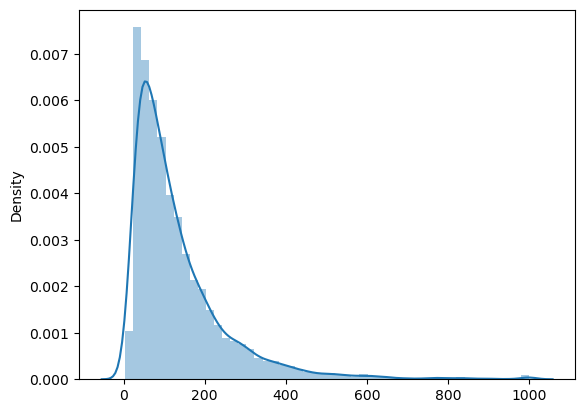

In [79]:
token_lens = []

for text in pandasDF.text:
    tokens = tokenizer.encode(text, max_length = 1000)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)

Based on the distplot, we will pick a max_length of around 400 tokens.

In [72]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

texts = pandasDF['text'].tolist()
labels = pandasDF['stars'].tolist()

# List of token IDs representing the actual words in input
tokenizedId = []

# This tells BERT which parts it pay attention to by ignoring all the PAD(filler) tokens
tokenizedMask = []

# Encoding/tokenizing every review
for text in texts:
    encoded = tokenizer.encode_plus(
        text,
        max_length= 400,
        add_special_tokens= True,
        pad_to_max_length= True,
        return_attention_mask= True,
        return_tensors='pt'
    )
    
    tokenizedId.append(encoded['input_ids'])
    tokenizedMask.append(encoded['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [80]:
print(tokenizedId[1])
print(tokenizedMask[1])
print(labels[1])

tensor([  101,  2034,  1997,  2035,  1010,  1045,  2228,  2023,  2453,  2022,
         2026,  2034,  6300, 14277,  3319,  2055,  1000,  3435,  2833,  1012,
         1000,  2009,  1005,  1055,  2025,  1037,  6907,  1045,  2412,  4521,
         4983,  1045,  1005,  1049,  3140,  2000,  2006,  1037,  2346,  4440,
         1012,  2174,  1010,  1045,  2572,  2013,  6901,  1010,  6396,  1010,
         1998,  2572,  1037,  7975,  1011,  4344,  9530,  3630, 23491,  3126,
         1010,  2061,  1045,  2787,  2000,  2507,  2023,  2173,  1037,  3382,
         1012,  5678,  1010,  2009,  2001,  2006,  1037,  2346,  4440,  1997,
        11901,  1012,  2057,  2018,  2042,  2012,  1996,  3509,  2035,  2154,
         1998,  2020,  8576,  2067,  2188,  2000,  2430,  9925,  1012,  1996,
         2326,  2003,  6429,   999,  1045,  2031,  2196,  2464,  3435,  1011,
         2833,  3667,  2040,  2202,  2061,  2172,  6620,  1999,  2037,  5841,
         1012,  2122,  2111,  2020,  5948,  1996, 23564,  2595, 

### Creating Data Loader